In [1]:
import pickle
with open('train_qa.txt', 'rb') as file:
    data = pickle.load(file)

In [2]:
with open('test_qa.txt', 'rb') as file:
    data_test = pickle.load(file)

In [3]:
print(len(data))
print(len(data_test))

10000
1000


In [4]:
def see_data(data,n):
  Story = ' '
  for x in data[n][0]:
    Story = Story + x + ' '
  Question = ' '
  for y in data[n][1]:
    Question = Question + y + ' '
  Answer = ' '
  for z in data[n][2]:
    Answer = Answer + z
  print(f"Story: {Story}")
  print(f"Query: {Question}")
  print(f"Answer: {Answer}")


In [5]:
see_data(data,0)
see_data(data,1)
see_data(data,2)
see_data(data,3)

Story:  Mary moved to the bathroom . Sandra journeyed to the bedroom . 
Query:  Is Sandra in the hallway ? 
Answer:  no
Story:  Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . 
Query:  Is Daniel in the bathroom ? 
Answer:  no
Story:  Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom . 
Query:  Is Daniel in the office ? 
Answer:  no
Story:  Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom . Daniel picked up the football there . Daniel went to the bedroom . 
Query:  Is Daniel in the bedroom ? 
Answer:  yes


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Combine all data for tokenization
all_data = [item for sublist in data + data_test for item in sublist]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data)

vocab_size = len(tokenizer.word_index) + 1
max_story_len = max(map(len,(x for x,_,_ in data+data_test)))
max_question_len= max(map(len,(x for _,x,_ in data+data_test)))
def vectorize_stories(data, tokenizer, max_story_len, max_question_len, vocab_size):
    X_stories = []
    X_questions = []
    Y_answers = []

    for story, question, answer in data:
        story_seq = tokenizer.texts_to_sequences([story])[0]
        question_seq = tokenizer.texts_to_sequences([question])[0]

        # One-hot encode the answer
        answer_seq = np.zeros(vocab_size)
        answer_index = tokenizer.word_index[answer]
        answer_seq[answer_index] = 1

        X_stories.append(story_seq)
        X_questions.append(question_seq)
        Y_answers.append(answer_seq)

    return pad_sequences(X_stories, maxlen=max_story_len), pad_sequences(X_questions, maxlen=max_question_len), np.array(Y_answers)
X_story_train, X_question_train, Y_answer_train = vectorize_stories(data, tokenizer, max_story_len, max_question_len, vocab_size)
X_story_test, X_question_test, Y_answer_test = vectorize_stories(data_test, tokenizer, max_story_len, max_question_len, vocab_size)



In [7]:
print(max_story_len)
print(max_question_len)
print(len(X_story_train[0]))
print(len(X_question_train[0]))
print(len(Y_answer_train[0]))
print(len(X_story_test[0]))
print(len(X_question_test[0]))
print(len(Y_answer_test[0]))

156
6
156
6
38
156
6
38


In [8]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [9]:
from tensorflow.keras.layers import Input, Embedding, Dropout, dot, Activation, add, Permute, concatenate, SimpleRNN, Dense
from tensorflow.keras.models import Model

# Inputs
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))
embed_size = 100
# Encoding layers
M = Embedding(input_dim=vocab_size, output_dim=embed_size)(input_sequence)
C = Embedding(input_dim=vocab_size, output_dim=max_question_len)(input_sequence)
question_encoder = Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=max_question_len)(question)

# Operations
matcho = dot([M, question_encoder], axes=-1, normalize=False)
matcho = Activation('softmax')(matcho)

a_ = add([matcho,])
a_ = Permute((2, 1))(a_)

answers = concatenate([a_, question_encoder])

# Final layers
answers = SimpleRNN(50)(answers)
answers = Dropout(0.3)(answers)
answers = Dense(vocab_size)(answers)
answers = Activation('softmax')(answers)

# Model
model = Model(inputs=[input_sequence, question], outputs=answers)


In [10]:
model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 156, 100)             3800      ['input_1[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, 6, 100)               3800      ['input_2[0][0]']             
                                                                                              

In [12]:
history = model.fit([X_story_train,X_question_train],Y_answer_train,epochs = 50,validation_data = ([X_story_test,X_question_test],Y_answer_test))

Epoch 1/50
313/313 [==============================] - 7s 11ms/step - loss: 0.7867 - accuracy: 0.4981 - val_loss: 0.6972 - val_accuracy: 0.4970
Epoch 2/50
313/313 [==============================] - 3s 10ms/step - loss: 0.7094 - accuracy: 0.5036 - val_loss: 0.7060 - val_accuracy: 0.4970
Epoch 3/50
313/313 [==============================] - 3s 9ms/step - loss: 0.7022 - accuracy: 0.4973 - val_loss: 0.6952 - val_accuracy: 0.5030
Epoch 4/50
313/313 [==============================] - 4s 12ms/step - loss: 0.6977 - accuracy: 0.5019 - val_loss: 0.6987 - val_accuracy: 0.5030
Epoch 5/50
313/313 [==============================] - 3s 9ms/step - loss: 0.6965 - accuracy: 0.5072 - val_loss: 0.6938 - val_accuracy: 0.5030
Epoch 6/50
313/313 [==============================] - 3s 10ms/step - loss: 0.6952 - accuracy: 0.5121 - val_loss: 0.6931 - val_accuracy: 0.4970
Epoch 7/50
313/313 [==============================] - 3s 11ms/step - loss: 0.6058 - accuracy: 0.6656 - val_loss: 0.4675 - val_accuracy: 0.8040
E

In [13]:
import matplotlib.pyplot as plt

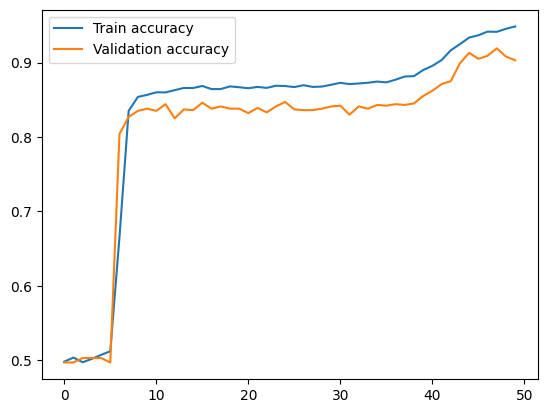

In [14]:
plt.plot(history.history['accuracy'],label="Train accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.legend()

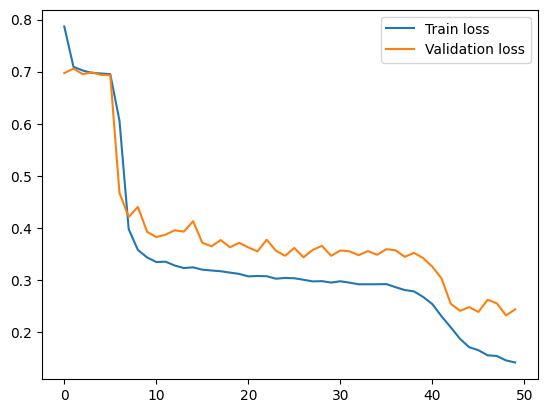

In [15]:
plt.plot(history.history['loss'],label="Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()

In [16]:
predictions = model.predict([X_story_test,X_question_test])

32/32 [==============================] - 0s 3ms/step


In [42]:
for i in range(0,10):
  Stories = ' '
  for x in data_test[i][0]:
    Stories = Stories + x + ' '
  Questions = ' '
  for y in data_test[i][1]:
    Questions = Questions + y + ' '
  print(f"Story: {Stories}")
  print(f"Question: {Questions}")
  print(f"Original Answer: {data_test[i][2]}")
  index = np.argmax(predictions[i])
  for x,y in tokenizer.word_index.items():
    if y == index:
      print(f"Predicted Answer: {x}")
      print("-----------------------------------------------------------------------------------------")

Story:  Mary got the milk there . John moved to the bedroom . 
Question:  Is John in the kitchen ? 
Original Answer: no
Predicted Answer: no
-----------------------------------------------------------------------------------------
Story:  Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . 
Question:  Is John in the kitchen ? 
Original Answer: no
Predicted Answer: no
-----------------------------------------------------------------------------------------
Story:  Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . Daniel moved to the bedroom . Daniel went to the garden . 
Question:  Is John in the garden ? 
Original Answer: yes
Predicted Answer: yes
-----------------------------------------------------------------------------------------
Story:  Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . Daniel moved to the bedroom . 